<a href="https://colab.research.google.com/github/ldivrala/Video-Classification/blob/main/VideoClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

Get Dataset

In [8]:
!tar xf ucf101_top5.tar.gz

In [10]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

In [11]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
train_df.head()

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot


Create pipeline for video to image features sequence

In [13]:
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)

def crop_center(frame):
  cropped = center_crop_layer(frame[None, ...])
  cropped = cropped.numpy().squeeze()
  return cropped


def load_video(path, max_frames = 0):
  cap = cv2.VideoCapture(path)
  frames = []

  try:
    while True:
      ret, frame = cap.read()
      
      if not ret:
        break

      frame = crop_center(frame)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:

        break
  
  finally:
   cap.release()
  
  return np.array(frames)


def build_feature_extractor():
  feature_extractor = keras.applications.DenseNet121(weights = "imagenet",
                                                     include_top = False,
                                                     pooling="avg",
                                                     input_shape = (IMG_SIZE, IMG_SIZE, 3))
  
  preprocess_input = keras.applications.densenet.preprocess_input

  inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
  preprocessed = preprocess_input(inputs)

  output = feature_extractor(preprocessed)

  return keras.Model(inputs, output, name = "feature_extractor")

feature_extractor = build_feature_extractor()

label_processor = keras.layers.StringLookup(num_oov_indices=0,
                                            vocabulary= np.unique(train_df["tag"]),
                                            mask_token = None)

print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


convert videos to image features sequence

In [56]:
def prepare_all_videos(df, root_dir = "/content/train"):
  df = df[:5]
  num_samples = len(df)
  
  video_paths = df["video_name"].values.tolist()
  labels = df["tag"].values
  labels = label_processor(labels[..., None]).numpy()

  frame_features = np.zeros(shape = (num_samples, MAX_SEQ_LENGTH, NUM_FEATURES),
                            dtype = "float32")
  
  for idx, path in enumerate(video_paths):
    frames = load_video(os.path.join(root_dir, path))

    frame_length = min(MAX_SEQ_LENGTH, len(frames))
    if len(frames) < MAX_SEQ_LENGTH:
      diff = MAX_SEQ_LENGTH - len(frames)
      padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
      frames = np.concatenate(frames, padding)

    
    
    temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES),
                                   dtype= "float32")
    

    temp_frame_features[:,:frame_length] = feature_extractor.predict(frames[:frame_length])

    frame_features[idx,] = temp_frame_features.squeeze()

  return frame_features, labels

In [60]:
train_data, train_labels = prepare_all_videos(train_df, root_dir = "/content/train")
test_data, test_labels = prepare_all_videos(test_df, root_dir = "/content/test")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


Create positional embedding

In [72]:
class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, output_length, **kwargs):
    super().__init__(**kwargs)

    self.positional_embedding = layers.Embedding(sequence_length, output_length)

    self.sequence_length = sequence_length
    self.output_length = output_length

  def call(self, inputs):
    length = tf.shape(inputs)[1]
    positions = tf.range(start=0, limit = length, delta = 1)
    embedded_positions = self.positional_embedding(positions)

    return inputs + embedded_positions

  def compute_mask(self, inputs, mask = None):
    mask = tf.reduce_any(tf.cast(inputs, "bool"), axis = -1)
    return mask

  

Transformer Encoder Layer

In [73]:
class TransformerEncoding(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)

    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads

    self.attention = layers.MultiHeadAttention(num_heads=num_heads, 
                                               key_dim=embed_dim, 
                                               dropout=0.3)
    
    self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation=tf.nn.gelu), 
                                        layers.Dense(embed_dim)])
    
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()

  def call(self, inputs, mask = None):
    if mask is not None:
      mask = mask[:, tf.newaxis, :]
    
    attention_output = self.attention(inputs, inputs, attention_mask = mask)
    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)

    return self.layernorm_2(proj_input + proj_output)

Ready Model

In [77]:
def get_compiled_model():
  sequence_length = MAX_SEQ_LENGTH
  embed_dim = NUM_FEATURES
  dense_dim = 4
  num_heads = 1
  classes = len(label_processor.get_vocabulary())

  inputs = keras.Input(shape=(sequence_length, embed_dim))
  x = PositionalEmbedding(sequence_length, embed_dim,name="positional_embedding")(inputs)

  x = TransformerEncoding(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)

  x = layers.GlobalMaxPooling1D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(classes, activation="softmax")(x)

  model = keras.Model(inputs, outputs)

  model.compile(
      optimizer="adam",
      loss="sparse_categorical_crossentropy",
      metrics = ["accuracy"]
  )

  return model

Get trained model

In [78]:
def run_experiment():
  file_path = "/content/tmp/video_classifier"

  checkpoint = keras.callbacks.ModelCheckpoint(file_path, 
                                               save_best_only=True, 
                                               save_weights_only=True,
                                               verbose = 1)
  
  model = get_compiled_model()

  history = model.fit(train_data, 
                      train_labels,
                      validation_split = 0.15,
                      epochs = EPOCHS,
                      callbacks=[checkpoint])
  
  model.load_weights(file_path)
  _, accuracy = model.evaluate(test_data, test_labels)

  print(f"Test accuracy: {round(accuracy * 100, 2)}%")

  return model

In [79]:
trained_model = run_experiment()

Epoch 1/5
16/16 [==============================] - 9s 431ms/step - loss: 2.2695 - accuracy: 0.5774 - val_loss: 0.5125 - val_accuracy: 0.7778

Epoch 00001: val_loss improved from inf to 0.51250, saving model to /content/tmp/video_classifier
Epoch 2/5
16/16 [==============================] - 7s 409ms/step - loss: 0.3280 - accuracy: 0.9008 - val_loss: 0.0484 - val_accuracy: 0.9778

Epoch 00002: val_loss improved from 0.51250 to 0.04839, saving model to /content/tmp/video_classifier
Epoch 3/5
16/16 [==============================] - 6s 403ms/step - loss: 0.0475 - accuracy: 0.9821 - val_loss: 0.4022 - val_accuracy: 0.8556

Epoch 00003: val_loss did not improve from 0.04839
Epoch 4/5
16/16 [==============================] - 6s 406ms/step - loss: 0.0218 - accuracy: 0.9921 - val_loss: 0.5178 - val_accuracy: 0.8333

Epoch 00004: val_loss did not improve from 0.04839
Epoch 5/5
16/16 [==============================] - 6s 402ms/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.7664 - val_accura

In [80]:
trained_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 20, 1024)]        0         
_________________________________________________________________
positional_embedding (Positi (None, 20, 1024)          20480     
_________________________________________________________________
transformer_layer (Transform (None, 20, 1024)          4211716   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 5125      
Total params: 4,237,321
Trainable params: 4,237,321
Non-trainable params: 0
___________________________________________________

See our result

Test video path: v_ShavingBeard_g03_c01.avi
  ShavingBeard: 100.00%
  Punch:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%
  TennisSwing:  0.00%



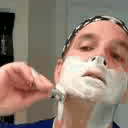

In [82]:
def prepare_single_video(frames):

  frame_length = min(MAX_SEQ_LENGTH, len(frames))

  frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES),
                                  dtype= "float32")
  

  frame_features[:,:frame_length] = feature_extractor.predict(frames[:frame_length])

  return frame_features

def predict_action(path):
  class_vocab = label_processor.get_vocabulary()

  frames = load_video(os.path.join("test", path))
  frame_features = prepare_single_video(frames)
  probabilities = trained_model.predict(frame_features)[0]

  for i in np.argsort(probabilities)[::-1]:
      print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
  return frames


def to_gif(images):
  converted_images = images.astype(np.uint8)
  imageio.mimsave("animation.gif", converted_images, fps=10)
  return embed.embed_file("animation.gif")

test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])